In [117]:
import pandas as pd
pd.set_option('display.max_rows', 200)
import numpy as np

import time
import random

from os import getcwd 
from os.path import exists

getcwd() # current working directory

'D:\\project\\MIT_glyco'

In [2]:
version = 'v0'
update = False

In [3]:
save_name = "all_sites_group.csv"
all_sites = pd.read_csv(save_name)
print(all_sites.shape)
all_sites = all_sites.drop_duplicates(['name'], keep = 'first')
print(all_sites.shape)

(286, 3)
(275, 3)


> There are 11 duplicated proteins out of 286

In [4]:
import os
########## find the matching and non-matching proteins between all_sites and protein_chem ##########

all_sites['exists_in_chem'] = all_sites['name'].apply(lambda x: exists(f'./protein_chem/{x}'))
match_proteins = all_sites[all_sites['exists_in_chem']==True]

chem_folders = os.listdir('./protein_chem')
match_list = []
for name in match_proteins['name']:
    match_list.append(chem_folders.pop(chem_folders.index(name)))

chem_folders ### not matching folders at protein_chem directory

['A0A024RAY2',
 'features-all-names.csv',
 'features-all-names.xlsx',
 'P0CG62',
 'P63249',
 'P68406',
 'Q4R561_P60710',
 'Q62381',
 'Q69ZI1',
 'Q80TI1',
 'Q80TR8',
 'Q80YE7',
 'Q8BXL9',
 'Q91YE8',
 'Q9WVB1']

In [6]:
len(chem_folders)

15

>13 out of 101 proteins do not exist in "all_sites_group.csv"

In [7]:
########## 이 두개가 같아야 함 ##########
print(len(match_list))
print(match_list[:3])
print(match_list[-3:])

88
['A2ABU4', 'A2AHJ4', 'A2AKB9']
['P09951', 'P10636', 'P10637']


In [8]:
print(match_proteins.name.shape)
print(match_proteins.name.head(3).values)
print(match_proteins.name.tail(3).values)
########## 이 두개가 같아야 함 ##########

(88,)
['A2ABU4' 'A2AHJ4' 'A2AKB9']
['P09951' 'P10636' 'P10637']


In [9]:
########## load names of chemical features ########## 

chem_columns = pd.read_csv(f'./protein_chem/features-all-names.csv', header=None).loc[0].values
print(chem_columns.shape)
print(chem_columns[:3])
print(chem_columns[-3:])

(159,)
['protein_name' 'residue_SER_THR' 'number_of_hydrophobic']
['exposed_negative_charge_all_backbone_with_around_target_ser_thr'
 'exposed_negative_charge_all_sidechain_with_around_target_ser_thr'
 'classifier']


In [73]:
chem_data = []
for name in match_list:
    if name == 'A2ABU4':
        data = pd.read_csv(f'./protein_chem/{name}/combined-output-all-features.csv', header=None)
        data.columns = chem_columns[:-1]
        data = data.sort_values(by='residue_SER_THR')
        chem_data.append(data)
    else:
        data = pd.read_csv(f'./protein_chem/{name}/combined-output-all-features.csv', sep=' ', header=None)
        data["protein_name"] = name
        data.columns = list(chem_columns[1:-1]) + ['protein_name']
        data = data[chem_columns[:-1]]
        data = data.sort_values(by='residue_SER_THR')
        chem_data.append(data)
        
chem_data = pd.concat(chem_data)
chem_data = chem_data.reset_index(drop=True)
chem_data = chem_data.rename(columns={
    "protein_name":"name",
    "residue_SER_THR":"index"
})

In [74]:
chem_data.shape

(10430, 158)

# data preparation

In [75]:
load_name = f'data_for_ml_v3.csv'
ml_data = pd.read_csv(load_name, header=0, index_col=0) 
ml_data = ml_data[ml_data['name'].apply(lambda x: x in match_list)]

ml_data_positive = ml_data[ml_data["positive"]==1]
ml_data_negative = ml_data[ml_data["positive"]==0]
print("total number of positive sites:", len(ml_data_positive))
print("total number of negative sites:", len(ml_data_negative))

ml_data['index'] = ml_data['index'].apply(lambda x: x+1)
ml_data = ml_data.reset_index(drop=True)
ml_data.head(3)

total number of positive sites: 223
total number of negative sites: 10207


,name,index,SEQ,positive,window,nSer,nThr,nAli,nPos,P_after,...,ASA,Phi,Psi,Theta(i-1=>i+1),Tau(i-2=>i+2),HSE_alpha_up,HSE_alpha_down,P(C),P(H),P(E)
0,A2ABU4,2,T,0,"M""T""LPHSPGSAGE",2,0,0,0,False,...,103.3,-102.0,132.1,117.6,-150.0,3.8,13.9,0.839,0.011,0.150
1,A2ABU4,6,S,0,"MTLPH""S""PGSAGEPQAS",2,1,2,0,True,...,60.0,-87.4,138.5,115.2,-125.9,7.8,16.7,0.925,0.005,0.070
2,A2ABU4,9,S,0,"MTLPHSPG""S""AGEPQASQTV",2,2,1,0,False,...,56.1,-89.9,142.4,116.8,121.2,8.2,13.9,0.895,0.039,0.067


In [89]:
ml_data

,name,index,SEQ,positive,window,nSer,nThr,nAli,nPos,P_after,...,ASA,Phi,Psi,Theta(i-1=>i+1),Tau(i-2=>i+2),HSE_alpha_up,HSE_alpha_down,P(C),P(H),P(E)
0,A2ABU4,2,T,0,"M""T""LPHSPGSAGE",2,0,0,0,False,...,103.3,-102.0,132.1,117.6,-150.0,3.8,13.9,0.839,0.011,0.150
1,A2ABU4,6,S,0,"MTLPH""S""PGSAGEPQAS",2,1,2,0,True,...,60.0,-87.4,138.5,115.2,-125.9,7.8,16.7,0.925,0.005,0.070
2,A2ABU4,9,S,0,"MTLPHSPG""S""AGEPQASQTV",2,2,1,0,False,...,56.1,-89.9,142.4,116.8,121.2,8.2,13.9,0.895,0.039,0.067
3,A2ABU4,16,S,0,"SPGSAGEPQA""S""QTVQVHRLEH",2,1,2,0,False,...,75.5,-82.7,22.5,104.9,-107.4,5.9,14.2,0.681,0.295,0.023
4,A2ABU4,18,T,0,"GSAGEPQASQ""T""VQVHRLEHRQ",2,0,1,0,False,...,78.2,-96.3,112.1,112.0,84.6,5.8,13.7,0.445,0.233,0.322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10425,P10637,708,S,0,"RHLSNVSSTG""S""IDMVDSPQLA",4,1,0,0,False,...,36.8,-97.3,126.1,113.9,-121.0,13.1,19.9,0.739,0.048,0.213
10426,P10637,714,S,0,"SSTGSIDMVD""S""PQLATLADEV",3,2,1,0,True,...,39.8,-91.4,135.9,117.7,137.8,14.5,12.2,0.964,0.026,0.010
10427,P10637,719,T,0,"IDMVDSPQLA""T""LADEVSASLA",3,0,2,0,False,...,57.4,-100.2,132.7,115.6,137.2,10.1,20.3,0.330,0.484,0.187
10428,P10637,725,S,0,"PQLATLADEV""S""ASLAKQGL",1,1,1,0,False,...,29.2,-101.3,139.3,117.9,-173.0,12.6,23.0,0.310,0.623,0.067


In [90]:
chem_data

,name,index,number_of_hydrophobic,number_of_hydrophilic,number_of_polar,number_of_aromatic,number_of_aliphatic,number_of_charged,number_of_positive,number_of_negative,...,exposed_positive_charge_all_backbone_around_target_ser_thr,exposed_positive_charge_all_sidechain_around_target_ser_thr,exposed_positive_charge_all_backbone_with_around_target_ser_thr,exposed_positive_charge_all_sidechain_with_around_target_ser_thr,exposed_negative_charge_all_around_target_ser_thr,exposed_negative_charge_all_with_around_target_ser_thr,exposed_negative_charge_all_backbone_around_target_ser_thr,exposed_negative_charge_all_sidechain_around_target_ser_thr,exposed_negative_charge_all_backbone_with_around_target_ser_thr,exposed_negative_charge_all_sidechain_with_around_target_ser_thr
0,A2ABU4,2,3,1,0,0,1,1,1,0,...,1.62,3.43,1.62,4.22,-5.52,-7.43,-3.06,-2.46,-4.04,-3.39
1,A2ABU4,6,3,2,1,0,2,1,1,0,...,2.73,3.74,3.24,4.40,-7.28,-8.92,-4.56,-2.72,-5.54,-3.38
2,A2ABU4,9,2,2,1,0,3,1,0,1,...,2.64,1.40,3.22,2.06,-5.67,-7.31,-4.76,-0.91,-5.74,-1.57
3,A2ABU4,16,3,3,3,0,2,0,0,0,...,2.92,4.39,3.43,5.05,-9.34,-10.98,-4.90,-4.44,-5.88,-5.10
4,A2ABU4,18,3,4,3,0,3,1,1,0,...,3.34,5.63,3.92,6.42,-10.36,-12.27,-4.94,-5.42,-5.92,-6.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10425,P10637,708,3,4,3,0,3,1,0,1,...,2.69,3.60,3.20,4.26,-10.19,-11.83,-4.92,-5.27,-5.90,-5.93
10426,P10637,714,8,5,3,0,5,2,0,2,...,3.57,8.33,4.08,8.99,-14.73,-16.37,-5.74,-8.99,-6.72,-9.65
10427,P10637,719,7,8,4,0,6,4,1,3,...,4.66,8.61,5.17,9.40,-19.52,-21.43,-8.68,-10.84,-9.66,-11.77
10428,P10637,725,9,6,3,0,10,3,1,2,...,6.53,9.23,7.04,9.89,-21.40,-22.57,-11.71,-9.69,-12.22,-10.35


In [94]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10430 entries, 0 to 10429
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             10430 non-null  object 
 1   index            10430 non-null  int64  
 2   SEQ              10430 non-null  object 
 3   positive         10430 non-null  int64  
 4   window           10430 non-null  object 
 5   nSer             10430 non-null  int64  
 6   nThr             10430 non-null  int64  
 7   nAli             10430 non-null  int64  
 8   nPos             10430 non-null  int64  
 9   P_after          10430 non-null  object 
 10  flexibility      10430 non-null  float64
 11  SS               10430 non-null  object 
 12  SS_angle         10430 non-null  object 
 13  side-1           10430 non-null  object 
 14  side1            10430 non-null  object 
 15  side2            10430 non-null  object 
 16  side3            10430 non-null  object 
 17  side4       

In [92]:
ml_data_aug = pd.concat([ml_data, chem_data.iloc[:,39:]], axis=1)
ml_data_aug = ml_data_aug.astype({'nSer': 'object', 'nThr': 'object', 'nAli': 'object', 'nPos': 'object'})

In [99]:
cat_columns = ["nSer", "nThr", "nAli", "nPos", "P_after", "SEQ", "SS", "SS_angle", "side-1", "side1", "side2", "side3", "side4", "side5"]
ml_data_cat = pd.get_dummies(ml_data_aug[cat_columns])
print("categorical data:", ml_data_cat.shape)
display(ml_data_cat.head(1))

print()

cts_columns = ["flexibility"] + list(ml_data_aug.columns[-119:])
ml_data_cts = pd.get_dummies(ml_data_aug[cts_columns])
print("continuous data:", ml_data_cts.shape)
display(ml_data_cts.head(1))

print()

y_columns = ["positive"]
ml_data_y = ml_data_aug[y_columns]
print("label data:", ml_data_y.shape)
display(ml_data_y.head(1))

categorical data: (10430, 88)


C:\Users\honsu\AppData\Local\Temp\ipykernel_19160\3135848795.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  ml_data_cat = pd.get_dummies(ml_data_aug[cat_columns])


,nSer_0,nSer_1,nSer_2,nSer_3,nSer_4,nSer_5,nSer_6,nSer_7,nSer_8,nSer_9,...,side4_small,side4_very small,side5_0,side5_cycle,side5_gly,side5_long,side5_normal,side5_pro,side5_small,side5_very small
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0



continuous data: (10430, 120)


,flexibility,sasa_hydrophobic,sasa_hydrophilic,sasa_polar,sasa_aromatic,sasa_aliphatic,sasa_charged,sasa_positive,sasa_negative,sasa_g,...,exposed_positive_charge_all_backbone_around_target_ser_thr,exposed_positive_charge_all_sidechain_around_target_ser_thr,exposed_positive_charge_all_backbone_with_around_target_ser_thr,exposed_positive_charge_all_sidechain_with_around_target_ser_thr,exposed_negative_charge_all_around_target_ser_thr,exposed_negative_charge_all_with_around_target_ser_thr,exposed_negative_charge_all_backbone_around_target_ser_thr,exposed_negative_charge_all_sidechain_around_target_ser_thr,exposed_negative_charge_all_backbone_with_around_target_ser_thr,exposed_negative_charge_all_sidechain_with_around_target_ser_thr
0,0.384,494.437225,118.922615,0.0,0.0,154.228073,118.922615,118.922615,0.0,0.0,...,1.62,3.43,1.62,4.22,-5.52,-7.43,-3.06,-2.46,-4.04,-3.39



label data: (10430, 1)


,positive
0,0


## common settings

In [102]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

patience = 20
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

In [103]:
def basicMLP(x_dim, y_dim, n_layers, n_neurons):
    mlp_input = Input(shape=(x_dim,), name='dense_input')
    
    # MLP module
    for i in range(n_layers):
        if i==0:
            dense_output = Dense(n_neurons, name=f"dense_{i+1}")(mlp_input)
        else: 
            dense_output = Dense(n_neurons, name=f"dense_{i+1}")(dense_output)
    mlp_output = Dense(y_dim, name=f"dense_output", activation='sigmoid')(dense_output)
    
    model = Model(mlp_input, mlp_output)
    optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy',optimizer = optimizer, metrics=['accuracy'])
    
    return model

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_confusion(y_real, y_pred, title, label=["True", "False"], size=4):
    if y_real.max() == 1:
        cm = confusion_matrix(y_real, y_pred)
        cm = cm.flatten()[::-1].reshape(2,2)
        plt.figure(figsize=(size*1.2,size))
        heatmap(cm, annot=True, fmt='.0f',
                cmap='Blues', 
                xticklabels=label, yticklabels=label)
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("Real")
        plt.show()
        
        accuracy  = 100*np.array(accuracy_score(y_real, y_pred)).round(4)
        precision = 100*np.array(precision_score(y_real, y_pred, average=None)).round(4)
        recall    = 100*np.array(recall_score(y_real, y_pred, average=None)).round(4)
        f1        = 100*np.array(f1_score(y_real, y_pred, average=None)).round(4)
        print(f"accuracy  : {accuracy}")
        print(f"precision : {precision}")
        print(f"recall    : {recall}")
        print(f"f1_score  : {f1}")

In [107]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_split(data_x, data_y, random_state=1, test_size=0.2, n_splits=1, dtype='arr'):
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    train_x,train_y, test_x, test_y  = [], [], [], []
    
    if dtype=='df':
        data_x = data_x.values
        data_y = data_y.values
    
    for train_index, test_index in split.split(data_x, data_y):
        train_x.append(data_x[train_index])
        train_y.append(data_y[train_index])

        test_x.append(data_x[test_index])
        test_y.append(data_y[test_index])
        
    print("train/test dataset")
    print("train:", train_x[0].shape, train_y[0].shape)
    print("test:", test_x[0].shape, test_y[0].shape)
    
    if n_splits == 1:
        return train_x[0],train_y[0], test_x[0], test_y[0]
    else:
        return train_x, train_y, test_x, test_y

## MLP model with augmeted dataset

In [109]:
### select input/output variables of machine learning model ###
x_cts = cts_columns
x_cat = cat_columns

y_cts = ["positive"]
y_cat = []

var_x = x_cts + x_cat
var_y = y_cts + y_cat

### make dummy dataset of categorical variables ###
data = ml_data_aug.copy()

data_x_cts = data[x_cts]
data_x_cat = data[x_cat].astype('object')
data_x_cat = pd.get_dummies(data_x_cat)

### split data into train/test dataset ###
valid_size = 0.15
test_size = 0.2
random_state = 1

data_x = pd.concat([data_x_cts, data_x_cat], axis=1)
data_y = data[var_y]
train_x, train_y, test_x, test_y = stratified_split(data_x, data_y, random_state=random_state, test_size=test_size,
                                                    dtype='df')

### data scaling of continuous variables ###
train_x_sc = train_x[:,:len(x_cts)]
test_x_sc = test_x[:,:len(x_cts)]

x_min = train_x_sc.min(axis=0)
x_max = train_x_sc.max(axis=0)

train_x_sc = (train_x_sc-x_min)/(x_max-x_min)
test_x_sc = (test_x_sc-x_min)/(x_max-x_min)

train_x[:,:len(x_cts)] = train_x_sc
test_x[:,:len(x_cts)] = test_x_sc

train/test dataset
train: (8344, 208) (8344, 1)
test: (2086, 208) (2086, 1)


C:\Users\honsu\AppData\Local\Temp\ipykernel_19160\2577939607.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data_x_cat = pd.get_dummies(data_x_cat)


In [118]:
random_state = 1

### upsampling for train dataset ###
index_pos = np.where(train_y == 1)[0]
index_neg = np.where(train_y == 0)[0]

random.seed(random_state)
up_index = [random.choice(index_pos) for _ in range(len(index_neg))] # get samples from positive sites as much as the number of negative sites

sample_pos_x = train_x[up_index]
sample_pos_y = train_y[up_index]
sample_neg_x = train_x[index_neg]
sample_neg_y = train_y[index_neg]

sample_x = np.concatenate([sample_pos_x, sample_neg_x], axis=0)
sample_y = np.concatenate([sample_pos_y, sample_neg_y], axis=0)

shuffle_index = np.arange(len(sample_x))
np.random.seed(random_state)
np.random.shuffle(shuffle_index)
sample_x = sample_x[shuffle_index]
sample_y = sample_y[shuffle_index]


print("up-sampled train dataset:", sample_x.shape, sample_y.shape)
print("test dataset:", test_x.shape, test_y.shape)

up-sampled train dataset: (16332, 208) (16332, 1)
test dataset: (2086, 208) (2086, 1)


In [125]:
model_type = 'basicMLP_sample_augmented'
x_dim = sample_x.shape[1]
y_dim = sample_y.shape[1]

parameter_config = {
    "method" : "random",
    "counts" : 100,
    "n_layers" : range(1,20),
    "n_neurons" : range(1, 501)
}

method = parameter_config["method"]
counts = parameter_config["counts"]

hpo_result = []
for i in range(21):
    print(f"random: {i+1} of {counts}")
    random.seed(i+1)
    n_layers = random.choice(parameter_config["n_layers"])
    n_neurons = random.choice(parameter_config["n_neurons"])
    print(f"n_layers:{n_layers}, n_neurons:{n_neurons}")
    
    model = basicMLP(x_dim, y_dim, n_layers, n_neurons)
    
    model_name = f"{model_type}_{version}_HPO_{i+1}_{counts}"
    save_path = f"./model/{model_name}.h5"
    history_path = f"./result/{model_name}.csv"

    if not exists(save_path) or update:
        tf.random.set_seed(random_state)
        time_start = time.time()
        history = model.fit(sample_x, sample_y, verbose=0,
                        epochs=1000, callbacks=[early_stopping_cb], validation_split= valid_size)
        model.save_weights(save_path)
        print(f"model is saved to: {save_path}")

        time_end = time.time()
        time_elapse = round((time_end - time_start)/60, 3)
        history_df = pd.DataFrame(history.history)
        history_df.index.name = f"{time_elapse} min"

        history_df.to_csv(history_path)
        print(f"history is saved to: {history_path}")

    else:
        model.load_weights(save_path)
        print(f"model is loaded from: {save_path}")  

        history_df = pd.read_csv(history_path, index_col=0, header=0)
        print(f"history is loaded from: {history_path}")
        
    best_index = history_df['val_loss'].argmin()
    test_evaluation  = model.evaluate(test_x, test_y, verbose=0)
    hpo_result.append([n_layers, n_neurons, 
                       history_df['loss'].iloc[best_index], history_df['val_loss'].iloc[best_index],
                       test_evaluation[0]
                      ])

random: 1 of 100
n_layers:5, n_neurons:292
model is loaded from: ./model/basicMLP_sample_augmented_v0_HPO_1_100.h5
history is loaded from: ./result/basicMLP_sample_augmented_v0_HPO_1_100.csv
random: 2 of 100
n_layers:2, n_neurons:47
model is loaded from: ./model/basicMLP_sample_augmented_v0_HPO_2_100.h5
history is loaded from: ./result/basicMLP_sample_augmented_v0_HPO_2_100.csv
random: 3 of 100
n_layers:8, n_neurons:304
model is loaded from: ./model/basicMLP_sample_augmented_v0_HPO_3_100.h5
history is loaded from: ./result/basicMLP_sample_augmented_v0_HPO_3_100.csv
random: 4 of 100
n_layers:8, n_neurons:156
model is loaded from: ./model/basicMLP_sample_augmented_v0_HPO_4_100.h5
history is loaded from: ./result/basicMLP_sample_augmented_v0_HPO_4_100.csv
random: 5 of 100
n_layers:9, n_neurons:380
model is loaded from: ./model/basicMLP_sample_augmented_v0_HPO_5_100.h5
history is loaded from: ./result/basicMLP_sample_augmented_v0_HPO_5_100.csv
random: 6 of 100
n_layers:19, n_neurons:421
mo

In [128]:
hpo_result

[[5, 292, 0.5222409963607788, 0.5387588143348694, 0.5484654307365417],
 [2, 47, 0.5199565887451172, 0.5387298464775085, 0.5280601978302002],
 [8, 304, 0.5246358513832092, 0.5378645062446594, 0.5328977108001709],
 [8, 156, 0.5221716165542603, 0.5388532280921936, 0.5408007502555847],
 [9, 380, 0.5321304798126221, 0.5388431549072266, 0.5255845785140991],
 [19, 421, 0.5636515617370605, 0.5579073429107666, 0.4818345308303833],
 [11, 486, 0.5368949770927429, 0.5441910028457642, 0.5410778522491455],
 [8, 190, 0.5233402252197266, 0.5381922721862793, 0.5422959923744202],
 [15, 314, 0.5413944721221924, 0.5448111295700073, 0.5568866729736328],
 [19, 17, 0.521219789981842, 0.5389708280563354, 0.5339409112930298],
 [15, 444, 0.54657381772995, 0.5442865490913391, 0.5501324534416199],
 [16, 138, 0.5242533087730408, 0.5378236174583435, 0.5311838984489441],
 [9, 149, 0.5212843418121338, 0.5382604598999023, 0.540099561214447],
 [4, 316, 0.5219708681106567, 0.5385523438453674, 0.5268068313598633],
 [7, 6

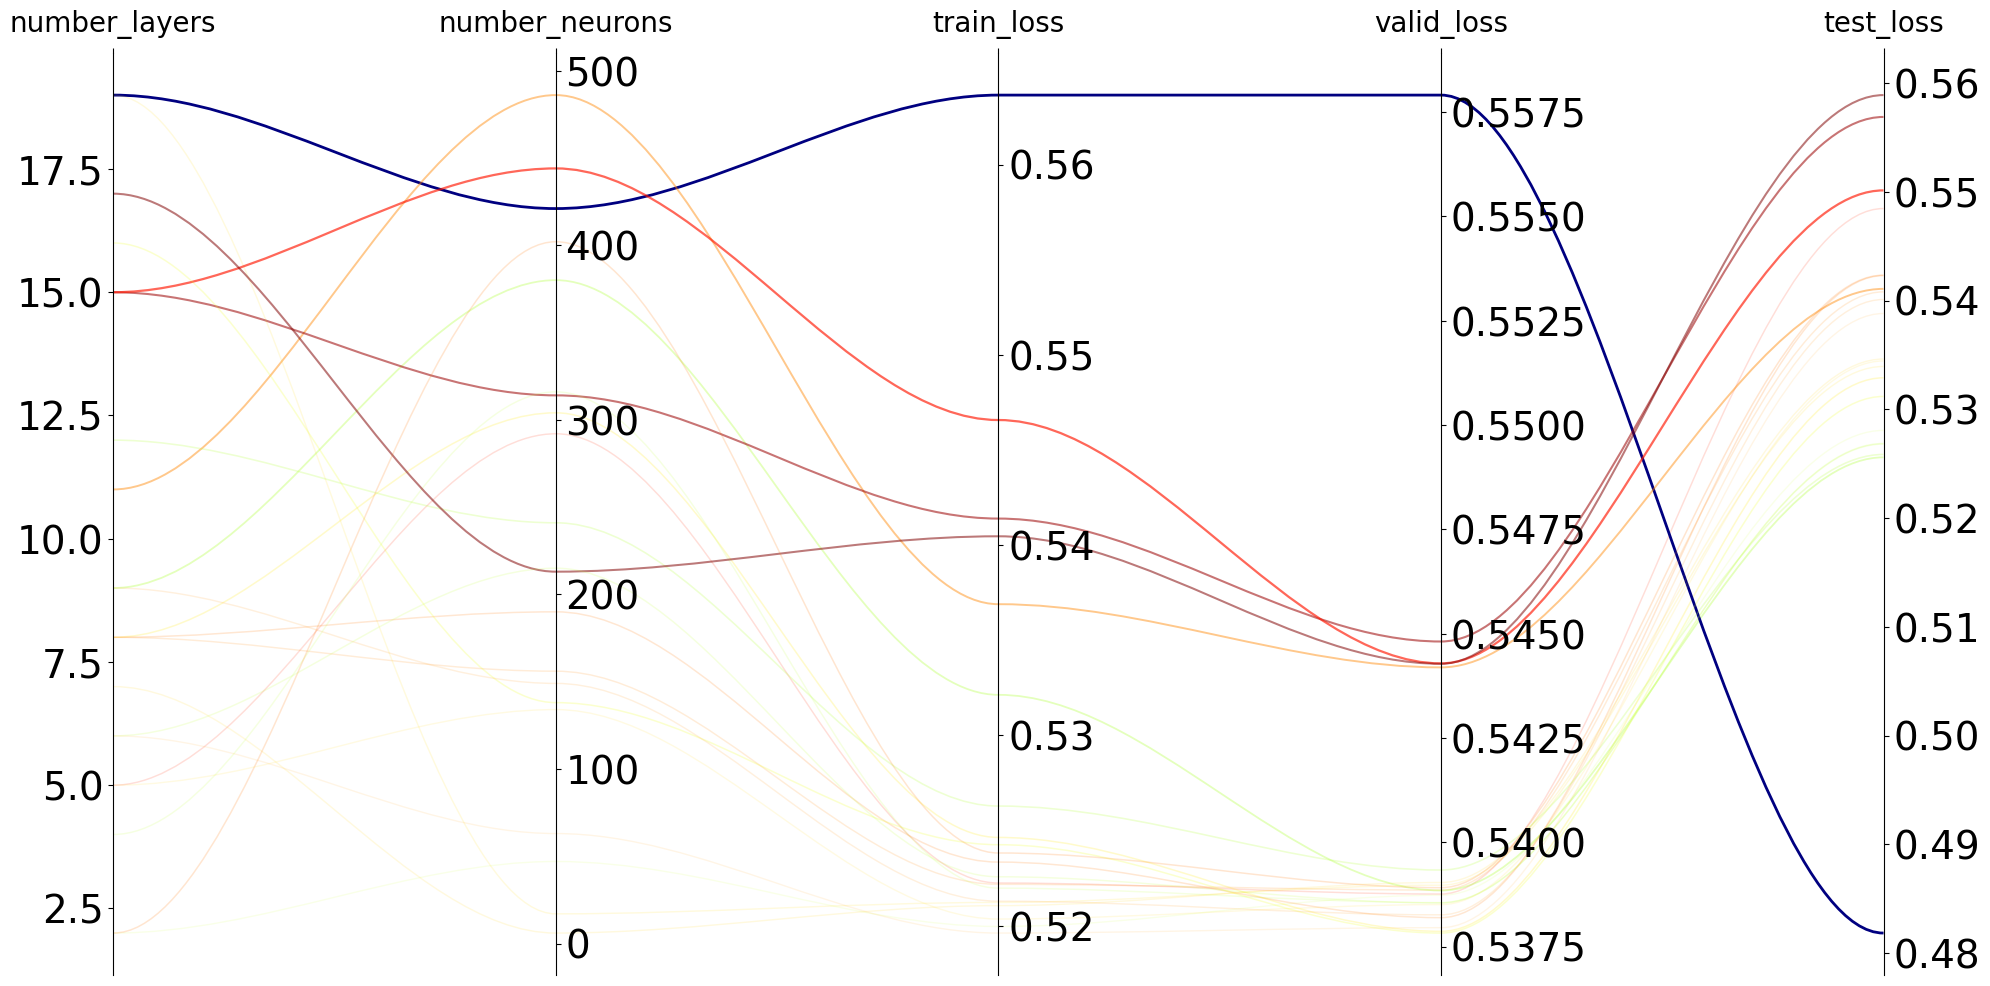

In [133]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl

# create some dummy data
ynames = ['number_layers', 'number_neurons', 'train_loss', 'valid_loss', 'test_loss']
y_arr = np.array(hpo_result)
ymins = y_arr.min(axis=0)
ymaxs = y_arr.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
z_arr = np.zeros_like(y_arr)
z_arr[:, 0] = y_arr[:, 0]
z_arr[:, 1:] = (y_arr[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(20,10))
axes = [host] + [host.twinx() for i in range(y_arr.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(labelsize=28)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (y_arr.shape[1] - 1)))

host.set_xlim(0, y_arr.shape[1] - 1)
host.set_xticks(range(y_arr.shape[1]))
host.set_xticklabels(ynames, fontsize=20)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
# host.set_title('Hyperparameter analysis', fontsize=28)

N = y_arr.shape[0]
target = -1
yt = y_arr[:,target]
t_min = yt.min()
t_max = yt.max()
yt_norm = (yt-t_min)/(t_max-t_min)*256

cmap = mpl.cm.get_cmap('jet')
c = y_arr[:,-1]
dummie_cax = host.scatter(c, c, c=c, cmap=cmap)
ax_min = z_arr.min()
ax_max = z_arr.max()
target_ax = -3

for j in range(N):
    # to just draw straight lines between the axes:
    # host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])

    # create bezier curves
    # for each axis, there will a control vertex at the point itself, one at 1/3rd towards the previous and one
    #   at one third towards the next axis; the first and last axis have one less control vertex
    # x-coordinate of the control vertices: at each integer (for the axes) and two inbetween
    # y-coordinate: repeat every point three times, except the first and last only twice
    verts = list(zip([x for x in np.linspace(0, N - 1, N * 3 - 2, endpoint=True)],
                     np.repeat(z_arr[j, :], 3)[1:-1]))
    # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    ax_z = (z_arr[:,target_ax][j]-ax_min)/(ax_max-ax_min)
    patch = patches.PathPatch(path, facecolor='none', lw=2-1*(1.0-ax_z), alpha=1-0.9*(1-ax_z), edgecolor=cmap(int(yt_norm[j])))
    host.add_patch(patch)


# fig.colorbar(dummie_cax)
plt.tight_layout()
plt.show()

In [135]:
hpo_result_new = hpo_result.copy()
hpo_result_new.pop(np.array(hpo_result_new).argmin(0)[4])

[19, 421, 0.5636515617370605, 0.5579073429107666, 0.4818345308303833]

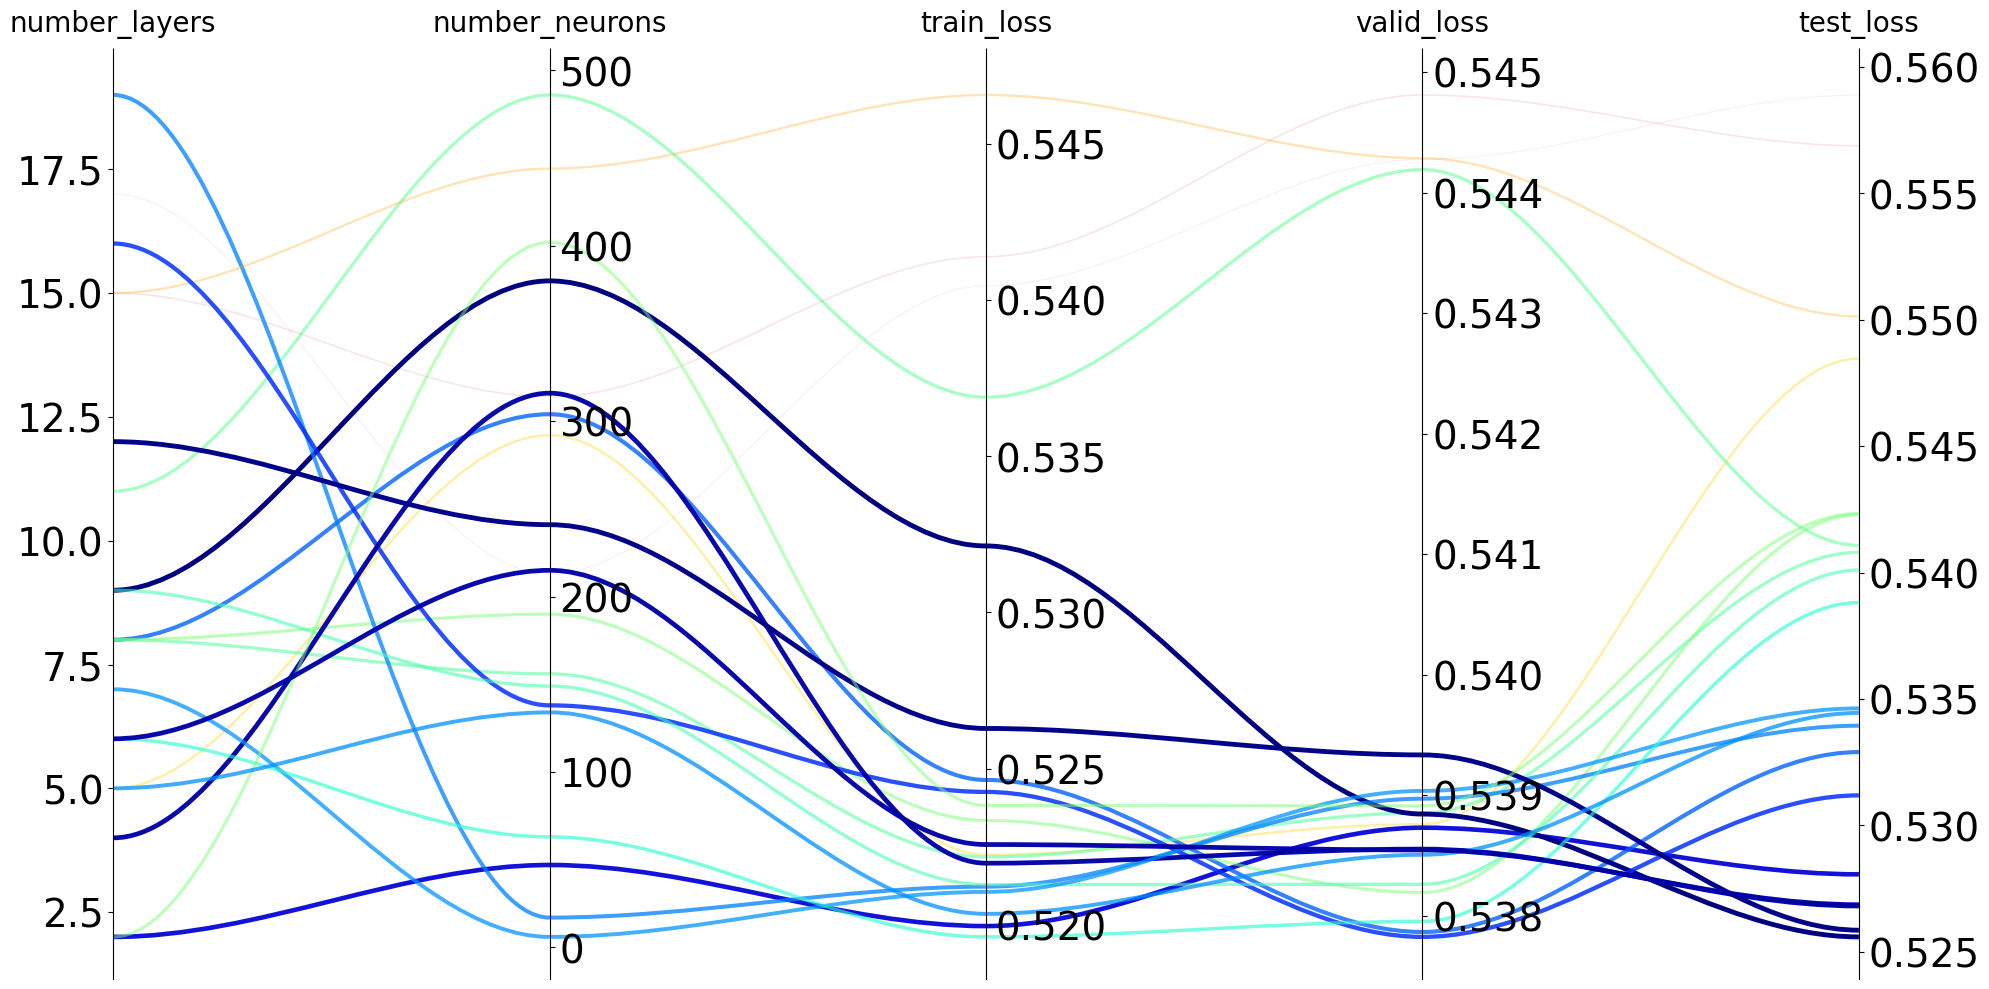

In [158]:
# create some dummy data
ynames = ['number_layers', 'number_neurons', 'train_loss', 'valid_loss', 'test_loss']
y_arr = np.array(hpo_result_new)
ymins = y_arr.min(axis=0)
ymaxs = y_arr.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
z_arr = np.zeros_like(y_arr)
z_arr[:, 0] = y_arr[:, 0]
z_arr[:, 1:] = (y_arr[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(20,10))
axes = [host] + [host.twinx() for i in range(y_arr.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(labelsize=28)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (y_arr.shape[1] - 1)))

host.set_xlim(0, y_arr.shape[1] - 1)
host.set_xticks(range(y_arr.shape[1]))
host.set_xticklabels(ynames, fontsize=20)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
# host.set_title('Hyperparameter analysis', fontsize=28)

N = y_arr.shape[0]
target = -1
yt = y_arr[:,target]
t_min = yt.min()
t_max = yt.max()
yt_norm = (yt-t_min)/(t_max-t_min)*256

cmap = mpl.cm.get_cmap('jet')
c = y_arr[:,-1]
dummie_cax = host.scatter(c, c, c=c, cmap=cmap)
ax_min = z_arr.min()
ax_max = z_arr.max()
target_ax = -1

for j in range(N):
    # to just draw straight lines between the axes:
    # host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])

    # create bezier curves
    # for each axis, there will a control vertex at the point itself, one at 1/3rd towards the previous and one
    #   at one third towards the next axis; the first and last axis have one less control vertex
    # x-coordinate of the control vertices: at each integer (for the axes) and two inbetween
    # y-coordinate: repeat every point three times, except the first and last only twice
    verts = list(zip([x for x in np.linspace(0, N - 1, N * 3 - 2, endpoint=True)],
                     np.repeat(z_arr[j, :], 3)[1:-1]))
    # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    ax_z = (z_arr[:,target_ax][j]-ax_min)/(ax_max-ax_min)
    patch = patches.PathPatch(path, facecolor='none', lw=3.5-2.5*(ax_z), alpha=1-0.95*(ax_z), edgecolor=cmap(int(yt_norm[j])))
    host.add_patch(patch)


# fig.colorbar(dummie_cax)
plt.tight_layout()
plt.show()

In [159]:
best_index = np.array(hpo_result_new)[:,-2:].sum(1).argmin()
best_index

4

In [160]:
hpo_result_new[best_index]

[9, 380, 0.5321304798126221, 0.5388431549072266, 0.5255845785140991]

In [163]:
best_hpo = hpo_result_new[best_index]
best_layers = best_hpo[0]
best_neurons = best_hpo[1]

best_model = basicMLP(x_dim, y_dim, best_layers, best_neurons)
model_name = f"{model_type}_{version}_HPO_{best_index+1}_{counts}"
save_path = f"./model/{model_name}.h5"
best_model.load_weights(save_path)

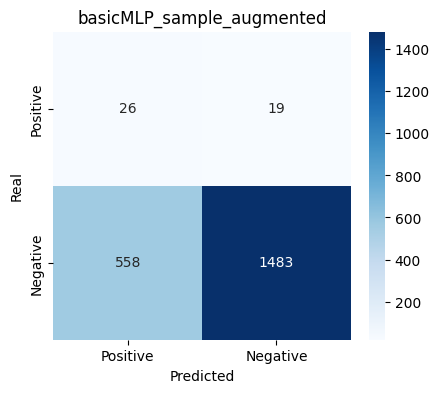

accuracy  : 72.34
precision : [98.74  4.45]
recall    : [72.66 57.78]
f1_score  : [83.71  8.27]


In [164]:
# evaluate the trained model
prediction = best_model.predict(test_x, verbose=0)
prediction = prediction.round(0).astype(int)

y_real = test_y
y_pred = prediction
    
plot_confusion(y_real, y_pred, title=model_type, label=["Positive","Negative"])

In [169]:
cat_columns = ["nSer", "nThr", "nAli", "nPos", "P_after", "SEQ", "SS", "SS_angle", "side-1", "side1", "side2", "side3", "side4", "side5"]
ml_data_cat = pd.get_dummies(ml_data_aug[cat_columns])
print("categorical data:", ml_data_cat.shape)
display(ml_data_cat.head(1))

print()

cts_columns = ["flexibility"]
ml_data_cts = pd.get_dummies(ml_data_aug[cts_columns])
print("continuous data:", ml_data_cts.shape)
display(ml_data_cts.head(1))

print()

y_columns = ["positive"]
ml_data_y = ml_data_aug[y_columns]
print("label data:", ml_data_y.shape)
display(ml_data_y.head(1))

categorical data: (10430, 88)


C:\Users\honsu\AppData\Local\Temp\ipykernel_19160\1252814841.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  ml_data_cat = pd.get_dummies(ml_data_aug[cat_columns])


,nSer_0,nSer_1,nSer_2,nSer_3,nSer_4,nSer_5,nSer_6,nSer_7,nSer_8,nSer_9,...,side4_small,side4_very small,side5_0,side5_cycle,side5_gly,side5_long,side5_normal,side5_pro,side5_small,side5_very small
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0



continuous data: (10430, 1)


,flexibility
0,0.384



label data: (10430, 1)


,positive
0,0


In [170]:
### select input/output variables of machine learning model ###
x_cts = cts_columns
x_cat = cat_columns

y_cts = ["positive"]
y_cat = []

var_x = x_cts + x_cat
var_y = y_cts + y_cat

### make dummy dataset of categorical variables ###
data = ml_data_aug.copy()

data_x_cts = data[x_cts]
data_x_cat = data[x_cat].astype('object')
data_x_cat = pd.get_dummies(data_x_cat)

### split data into train/test dataset ###
valid_size = 0.15
test_size = 0.2
random_state = 1

data_x = pd.concat([data_x_cts, data_x_cat], axis=1)
data_y = data[var_y]
train_x, train_y, test_x, test_y = stratified_split(data_x, data_y, random_state=random_state, test_size=test_size,
                                                    dtype='df')

### data scaling of continuous variables ###
train_x_sc = train_x[:,:len(x_cts)]
test_x_sc = test_x[:,:len(x_cts)]

x_min = train_x_sc.min(axis=0)
x_max = train_x_sc.max(axis=0)

train_x_sc = (train_x_sc-x_min)/(x_max-x_min)
test_x_sc = (test_x_sc-x_min)/(x_max-x_min)

train_x[:,:len(x_cts)] = train_x_sc
test_x[:,:len(x_cts)] = test_x_sc

train/test dataset
train: (8344, 89) (8344, 1)
test: (2086, 89) (2086, 1)


C:\Users\honsu\AppData\Local\Temp\ipykernel_19160\2577939607.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data_x_cat = pd.get_dummies(data_x_cat)


In [171]:
### upsampling for train dataset ###
index_pos = np.where(train_y == 1)[0]
index_neg = np.where(train_y == 0)[0]

random.seed(random_state)
up_index = [random.choice(index_pos) for _ in range(len(index_neg))] # get samples from positive sites as much as the number of negative sites

sample_pos_x = train_x[up_index]
sample_pos_y = train_y[up_index]
sample_neg_x = train_x[index_neg]
sample_neg_y = train_y[index_neg]

sample_x = np.concatenate([sample_pos_x, sample_neg_x], axis=0)
sample_y = np.concatenate([sample_pos_y, sample_neg_y], axis=0)

shuffle_index = np.arange(len(sample_x))
np.random.seed(random_state)
np.random.shuffle(shuffle_index)
sample_x = sample_x[shuffle_index]
sample_y = sample_y[shuffle_index]


print("up-sampled train dataset:", sample_x.shape, sample_y.shape)
print("test dataset:", test_x.shape, test_y.shape)

up-sampled train dataset: (16332, 89) (16332, 1)
test dataset: (2086, 89) (2086, 1)


In [174]:
model_type = 'basicMLP_sample_no_augmented'
x_dim = sample_x.shape[1]
y_dim = sample_y.shape[1]

n_layers = best_layers
n_neurons = best_neurons
print(f"n_layers:{n_layers}, n_neurons:{n_neurons}")
    
model = basicMLP(x_dim, y_dim, n_layers, n_neurons)
    
model_name = f"{model_type}_{version}_HPO_{i+1}_{counts}"
save_path = f"./model/{model_name}.h5"
history_path = f"./result/{model_name}.csv"

if not exists(save_path) or update:
    tf.random.set_seed(random_state)
    time_start = time.time()
    history = model.fit(sample_x, sample_y, verbose=0,
                    epochs=1000, callbacks=[early_stopping_cb], validation_split= valid_size)
    model.save_weights(save_path)
    print(f"model is saved to: {save_path}")

    time_end = time.time()
    time_elapse = round((time_end - time_start)/60, 3)
    history_df = pd.DataFrame(history.history)
    history_df.index.name = f"{time_elapse} min"

    history_df.to_csv(history_path)
    print(f"history is saved to: {history_path}")

else:
    model.load_weights(save_path)
    print(f"model is loaded from: {save_path}")  

    history_df = pd.read_csv(history_path, index_col=0, header=0)
    print(f"history is loaded from: {history_path}")

comparison_model = model

n_layers:9, n_neurons:380
model is saved to: ./model/basicMLP_sample_no_augmented_v0_HPO_5_100.h5
history is saved to: ./result/basicMLP_sample_no_augmented_v0_HPO_5_100.csv


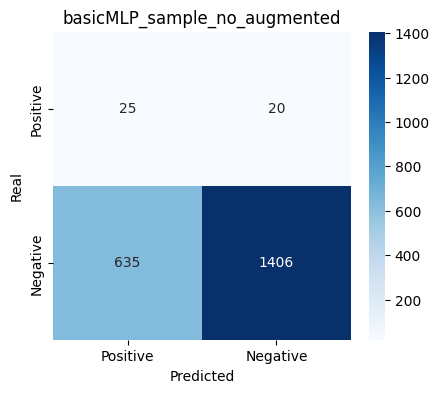

accuracy  : 68.60000000000001
precision : [98.6   3.79]
recall    : [68.89 55.56]
f1_score  : [81.11  7.09]


In [175]:
# evaluate the trained model
prediction = comparison_model.predict(test_x, verbose=0)
prediction = prediction.round(0).astype(int)

y_real = test_y
y_pred = prediction
    
plot_confusion(y_real, y_pred, title=model_type, label=["Positive","Negative"])